# Step 1: Calibration of camera intrinsic values

In [81]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
from itertools import count

In [82]:
CAMERA_ID = 'david'
SESSION_ID = '14-04-2021'
PROCESSED_IMAGE_NAME = 'result_247_247_4_7.png'
CHESSBOARD_SQUARE_LENGTH_MM = 1
CHESSBOARD_DIMENSIONS = (9,6)
CAPTURE_DEVICE = 0
EXTRINSIC_CALIBRATION_FRAME_COUNT = 120
PLANE_CALIBRATION_OBJECT_HEIGHT = 2.1

## Chessboard calibration (intrisinc parameters)

In [83]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
sample_object_points = np.zeros((CHESSBOARD_DIMENSIONS[0] * CHESSBOARD_DIMENSIONS[1],3), np.float32)

# TODO: check if this is the correct way to adjust the sizes. Used this accordint to: https://stackoverflow.com/questions/37310210/camera-calibration-with-opencv-how-to-adjust-chessboard-square-size
sample_object_points[:,:2] = np.mgrid[0:CHESSBOARD_DIMENSIONS[0],0:CHESSBOARD_DIMENSIONS[1]].T.reshape(-1,2) * CHESSBOARD_SQUARE_LENGTH_MM

# Swap axis so that the z axis is perpendicular to the chessboard
sample_object_points[:, [1, 0]] = sample_object_points[:, [0, 1]]

# Arrays to store object points and image points from all the images.
object_points = [] # 3d point in real world space
image_points = [] # 2d points in image plane.

images = glob.glob(f'data/calibration/{CAMERA_ID}/intrinsic/*.png')
print(f'Found {len(images)} calibration images')

for fname in images:
    image = cv2.imread(fname)
    grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, CHESSBOARD_DIMENSIONS, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        object_points.append(sample_object_points)

        improved_corners = cv2.cornerSubPix(grayscale_image, corners, (11,11), (-1,-1), criteria)
        image_points.append(improved_corners)
    else:
        print(f'Could not find chessboard corners in image {fname}')


Found 19 calibration images
Could not find chessboard corners in image data/calibration/david/intrinsic/calibration_frame_2021-04-02 16:39:56.783532.png
Could not find chessboard corners in image data/calibration/david/intrinsic/calibration_frame_2021-04-02 16:39:36.784381.png
Could not find chessboard corners in image data/calibration/david/intrinsic/calibration_frame_2021-04-02 16:38:46.784388.png
Could not find chessboard corners in image data/calibration/david/intrinsic/calibration_frame_2021-04-02 16:39:41.783697.png


### Intrinsic Parameters

In [84]:
ret, intrinsic_matrix, distortion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_points, image_points, grayscale_image.shape[::-1],None,None)
print('Image Dimensions')
print(grayscale_image.shape)
print('Intrinsic Matrix')
print(intrinsic_matrix)
print('Distortion Coefficients')
print(distortion_coefs)
print('Rotation Vectors')
print(rotation_vecs)
print('Translation Vectors')
print(translation_vecs)

Image Dimensions
(480, 640)
Intrinsic Matrix
[[563.75694837   0.         332.16377869]
 [  0.         558.41973892 215.1414695 ]
 [  0.           0.           1.        ]]
Distortion Coefficients
[[ 0.22044414 -0.71477837 -0.00554924 -0.00207883  0.98609804]]
Rotation Vectors
[array([[-2.21650946],
       [-2.05585281],
       [ 0.20860675]]), array([[ 0.1862303 ],
       [-2.96650025],
       [ 0.03416103]]), array([[ 1.11185453],
       [-2.75652626],
       [-0.09634553]]), array([[ 0.57000195],
       [-2.91079404],
       [-0.03637475]]), array([[ 1.48355727],
       [-2.58056638],
       [-0.13644684]]), array([[ 1.2813226 ],
       [-2.70197538],
       [-0.06340513]]), array([[ 2.10659329],
       [-2.12234605],
       [-0.18750236]]), array([[ 2.12104354],
       [-2.08528642],
       [-0.19283236]]), array([[-3.06576162],
       [-0.61681721],
       [ 0.25183365]]), array([[ 2.12594301],
       [-1.88991496],
       [-0.23549814]]), array([[ 2.13261022],
       [-2.1133617 ]

### Intrinsic Reprojection Error

In [85]:
def calculate_reprojection_error(objpoints, imgpoints, rvecs, tvecs, imatrix, distortion):
    mean_error = 0
    for i in range(len(objpoints)):
        calculted_image_points, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], imatrix, distortion)
        error = cv2.norm(imgpoints[i], calculted_image_points, cv2.NORM_L2)/len(calculted_image_points)
        mean_error += error

    return mean_error/len(objpoints)

In [86]:
print(f'Reprojection error: {calculate_reprojection_error(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

Reprojection error: 0.0305571624980066


## Chessboard calibration (extrinsic parameters)

In [87]:
'''
EXTRINSIC PARAMETERS
'''

# Arrays to store object points and image points from all the images.
object_points = [] # 3d point in real world space
image_points = [] # 2d points in image plane.

images = glob.glob(f'data/calibration/{CAMERA_ID}/{SESSION_ID}/extrinsic/*.png')
print(f'Found {len(images)} calibration images')

for fname in images:
    image = cv2.imread(fname)
    grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, CHESSBOARD_DIMENSIONS, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        object_points.extend(list(sample_object_points))
        improved_corners = cv2.cornerSubPix(grayscale_image, corners, (11,11), (-1,-1), criteria)
        image_points.extend(list(improved_corners))
    else:
        print(f'Could not find chessboard corners in {fname}')

object_points = np.float64(object_points)
image_points = np.float64(image_points)
print(object_points.shape)
print(image_points.shape)
  

Found 20 calibration images
(1080, 3)
(1080, 1, 2)


In [88]:
ret, rotation_vecs, translation_vecs, _ = cv2.solvePnPRansac(object_points, image_points, intrinsic_matrix, distortion_coefs)

### Extrinsic Reprojection Error

In [89]:
mean_error = 0

for i in range(len(object_points)):
    calulated_image_points, _ = cv2.projectPoints(object_points[i], rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)
    error = cv2.norm(image_points[i],calulated_image_points[0], cv2.NORM_L2)/len(calulated_image_points)
    mean_error += error

print(f'Reprojection error: {mean_error/len(object_points)}')

Reprojection error: 0.4967136343667528


## Projection Calculation

In [90]:
rotation_matrix = cv2.Rodrigues(rotation_vecs)[0]
extrinsic_matrix = np.concatenate((rotation_matrix, translation_vecs), axis=1)
perspective_projection_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
perspective_projection_matrix

array([[-2.59178576e+02,  5.63114381e+02, -2.09483490e+02,
         4.06708768e+03],
       [ 1.62310257e+02, -1.26148631e+01, -5.75859968e+02,
         6.62678667e+03],
       [-8.00584794e-01, -1.52159442e-03, -5.99217550e-01,
         2.35002615e+01]])

In [91]:
def get_xyz_coords(i, j, ppm, constraints = None):
    k1 = ppm[2] * i
    k2 = ppm[2] * j
    k3 = k1 - ppm[0]
    k4 = k2 - ppm[1]
    a = [k3[0:-1], k4[0:-1]]
    b = [-k3[-1], -k4[-1]]

    for constraint in constraints:
        a.append(np.array(constraint[0:-1]))
        b.append(np.array(constraint[-1]))
    res = np.linalg.solve(a, b)

    return res

## Shadow/Light Plane Calibration

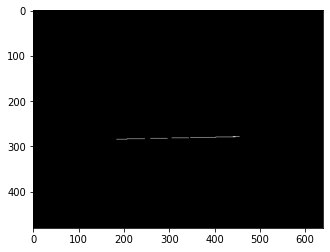

In [92]:
TEMP_SESSION = '13-04-2021b'
flat_image = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_flat/frame_2021-04-13 21:39:34.254860.png',cv2.IMREAD_GRAYSCALE)
height_image = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_height/intrujice.png', cv2.IMREAD_GRAYSCALE)
processed_bottom = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_flat/result_231_233_5_8-clean-clean.png', cv2.IMREAD_GRAYSCALE)
top_lines = cv2.subtract(height_image, processed_bottom)
ret, processed_top = cv2.threshold(top_lines, 240, 255, cv2.THRESH_BINARY)

processed_bottom = processed_bottom
processed_top = height_image
plt.imshow(processed_bottom, cmap='gray')

In [109]:
shadow_plane_3d_points = []

# 'Floor' points
white_pixel_coords = cv2.findNonZero(processed_bottom)
for pixel in white_pixel_coords:
    point = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[0,0,1,0]])
    shadow_plane_3d_points.append(point)
print(np.array(shadow_plane_3d_points)[:,0])
#print(white_pixel_coords)
# Object top points
white_pixel_coords = cv2.findNonZero(processed_top)
for pixel in white_pixel_coords:

    point = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[0,0,1, PLANE_CALIBRATION_OBJECT_HEIGHT]])
    shadow_plane_3d_points.append(point)

[0.10971339 0.11102096 0.1123284  0.11363572 0.11494292 0.11625
 0.11755695 0.11886377 0.12017048 0.12147706 0.12278351 0.12408984
 0.12539605 0.12670213 0.12800809 0.12048903 0.12179575 0.12310233
 0.1244088  0.12571514 0.12702135 0.12832744 0.12963341 0.13093926
 0.13224498 0.13355058 0.13485605 0.1361614  0.13746662 0.13877173
 0.1400767  0.14138156 0.14268629 0.1439909  0.14529538 0.14659974
 0.14790398 0.14920809 0.15051208 0.15181595 0.15311969 0.15442331
 0.1557268  0.15703017 0.15833342 0.15963655 0.16093955 0.16224243
 0.16354518 0.16484782 0.16615032 0.16745271 0.16875497 0.17005711
 0.17135912 0.17266102 0.17396278 0.17526443 0.17656595 0.1077324
 0.10904048 0.11034844 0.11165628 0.11296399 0.11427158 0.11557905
 0.11688639 0.1181936  0.1195007  0.12080766 0.12211451 0.12342123
 0.12472783 0.1260343  0.12734065 0.12864687 0.12995297 0.13125895
 0.1325648  0.13387053 0.13517614 0.13648162 0.13778698 0.13909221
 0.14039732 0.14170231 0.14300717 0.14431191 0.14561653 0.14692102

In [94]:
print(processed_bottom)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [95]:
# Calculate A,B,C and D parameters of the light/shadow plane using least squares method
plane_points = np.hstack((shadow_plane_3d_points, np.ones((len(shadow_plane_3d_points), 1)) * -1))
res = np.linalg.lstsq(plane_points, np.zeros((len(plane_points))), rcond=None)
print(res)

(array([0., 0., 0., 0.]), array([0.]), 4, array([119.85334878,  15.62270173,   7.26284376,   0.31808989]))


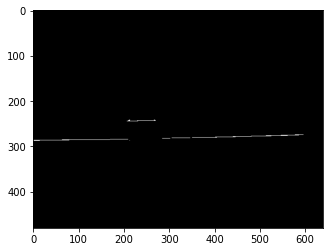

In [96]:
shadow_points = cv2.imread(f'data/calibration/{CAMERA_ID}/{SESSION_ID}/cube_processed/{PROCESSED_IMAGE_NAME}')
shadow_points_gray = cv2.cvtColor(shadow_points, cv2.COLOR_BGR2GRAY)
#plt.xticks([]), plt.yticks([])
plt.imshow(shadow_points, cmap='gray')

In [110]:
# Calculate y and z for points in shadow
points_y = []
points_z = []
points_x = []
white_pixel_coords = cv2.findNonZero(shadow_points_gray)
for pixel in white_pixel_coords:
    x, y, z = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[1,0,0,0]])
    points_y.append(y)
    points_z.append(z)
    points_x.append(x)


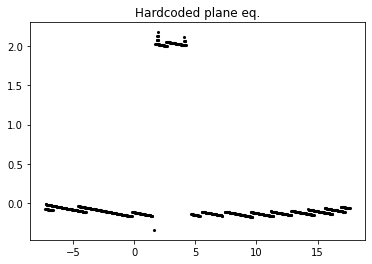

In [113]:
figure, subplots = plt.subplots(1)
points = []
subplots.set_title('Original')
subplots.scatter(points_y, points_z, color='black', marker='.', linewidths=0.1)
#plt.xlim([-5,9])
#plt.ylim([-3,3])
plt.title('Hardcoded plane eq.')
plt.show()

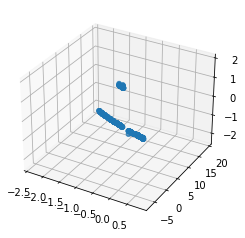

In [99]:
fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

  
# defining axes
ax.scatter(points_x, points_y, points_z)
#for ii in range(0,360,1):
#        ax.view_init(elev=10., azim=ii)
#        plt.savefig("movie/movie%d.png" % ii)



In [100]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
plane_points = np.hstack((shadow_plane_3d_points, np.ones((len(shadow_plane_3d_points), 1)) * -1))
reg = RANSACRegressor(base_estimator=LinearRegression(fit_intercept=True), residual_threshold=0.1).fit(plane_points, np.zeros((len(plane_points))))
reg.estimator_.coef_

array([0., 0., 0., 0.])

In [101]:
reg.get_params()

{'base_estimator__copy_X': True,
 'base_estimator__fit_intercept': True,
 'base_estimator__n_jobs': None,
 'base_estimator__normalize': False,
 'base_estimator__positive': False,
 'base_estimator': LinearRegression(),
 'is_data_valid': None,
 'is_model_valid': None,
 'loss': 'absolute_loss',
 'max_skips': inf,
 'max_trials': 100,
 'min_samples': None,
 'random_state': None,
 'residual_threshold': 0.1,
 'stop_n_inliers': inf,
 'stop_probability': 0.99,
 'stop_score': inf}

array([0., 0., 0., 0.])